## Import Packages

In [1]:
from spo.data import knapsack, dataset
from spo.model import knapsackModel
from spo.func import SPOPlus
from spo.eval import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(135)

## Init Data 

In [4]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, cor=False)

## Build Model 

In [5]:
# model for knapscak
cap = 30
ks_model = knapsackModel(weights, cap)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [6]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [7]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda=1e-3):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlus()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [8]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
cap = 30 # capacity
degs = [1, 2, 4, 6] # list of param deg

In [9]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [10]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-2
        num_epochs = 500
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 220.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 252.72it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [04:41<00:00,  1.77it/s]


Normalized SPO Loss: 0.51%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 233.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 239.51it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [04:09<00:00,  2.00it/s]


Normalized SPO Loss: 0.71%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 242.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [04:47<00:00,  1.74it/s]


Normalized SPO Loss: 1.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 277.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [04:35<00:00,  1.81it/s]


Normalized SPO Loss: 2.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 251.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.76it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [04:49<00:00,  1.73it/s]


Normalized SPO Loss: 1.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 266.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [04:18<00:00,  1.93it/s]


Normalized SPO Loss: 1.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 225.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [04:16<00:00,  1.95it/s]


Normalized SPO Loss: 0.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 272.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:07<00:00,  2.66it/s]


Normalized SPO Loss: 1.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 299.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:04<00:00,  2.71it/s]


Normalized SPO Loss: 0.69%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 307.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:05<00:00,  2.70it/s]


Normalized SPO Loss: 0.95%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 295.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:11<00:00,  2.62it/s]


Normalized SPO Loss: 0.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 286.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:05<00:00,  2.69it/s]


Normalized SPO Loss: 1.91%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 241.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:06<00:00,  2.68it/s]


Normalized SPO Loss: 3.65%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 284.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:05<00:00,  2.70it/s]


Normalized SPO Loss: 1.52%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 293.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.32it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:04<00:00,  2.71it/s]


Normalized SPO Loss: 1.02%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 307.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.01it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:02<00:00,  2.73it/s]


Normalized SPO Loss: 1.55%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 314.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.13it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:59<00:00,  2.79it/s]


Normalized SPO Loss: 2.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 284.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:17<00:00,  2.53it/s]


Normalized SPO Loss: 2.43%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:58<00:00,  2.80it/s]


Normalized SPO Loss: 2.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 278.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:54<00:00,  2.87it/s]


Normalized SPO Loss: 3.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 319.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.44it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


Normalized SPO Loss: 0.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 276.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:03<00:00,  2.72it/s]


Normalized SPO Loss: 0.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 296.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [03:19<00:00,  2.50it/s]


Normalized SPO Loss: 1.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.06it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:53<00:00,  2.89it/s]


Normalized SPO Loss: 2.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:56<00:00,  2.84it/s]


Normalized SPO Loss: 0.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:51<00:00,  2.91it/s]


Normalized SPO Loss: 1.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 278.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:54<00:00,  2.86it/s]


Normalized SPO Loss: 1.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 295.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:53<00:00,  2.88it/s]


Normalized SPO Loss: 2.45%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 312.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.90it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:52<00:00,  2.90it/s]


Normalized SPO Loss: 3.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 242.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:49<00:00,  2.95it/s]


Normalized SPO Loss: 3.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 309.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:56<00:00,  2.83it/s]


Normalized SPO Loss: 1.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 326.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 500/500 [02:47<00:00,  2.99it/s]


Normalized SPO Loss: 2.67%



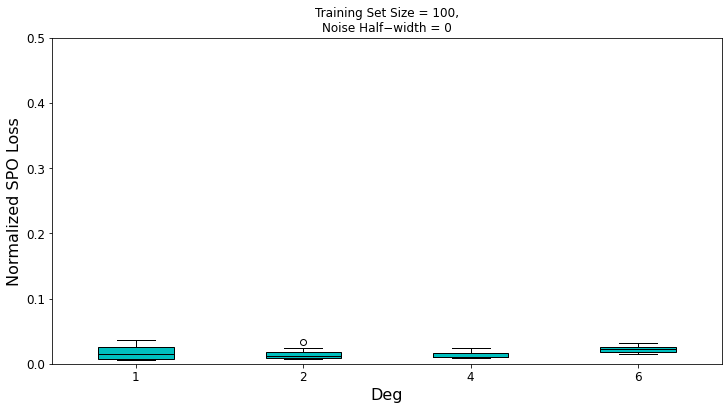

In [11]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [12]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [13]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [14]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-2
        num_epochs = 300
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 305.69it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:47<00:00,  2.78it/s]


Normalized SPO Loss: 12.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 270.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:40<00:00,  2.97it/s]


Normalized SPO Loss: 10.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 232.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:44<00:00,  2.87it/s]


Normalized SPO Loss: 9.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:40<00:00,  3.00it/s]


Normalized SPO Loss: 10.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:44<00:00,  2.88it/s]


Normalized SPO Loss: 15.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 293.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.39it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:43<00:00,  2.90it/s]


Normalized SPO Loss: 13.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 307.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:42<00:00,  2.93it/s]


Normalized SPO Loss: 9.58%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 369.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:52<00:00,  2.67it/s]


Normalized SPO Loss: 8.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 287.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:43<00:00,  2.90it/s]


Normalized SPO Loss: 13.34%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 307.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 225.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:44<00:00,  2.88it/s]


Normalized SPO Loss: 13.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 298.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 251.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:50<00:00,  2.71it/s]


Normalized SPO Loss: 11.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 282.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:46<00:00,  2.82it/s]


Normalized SPO Loss: 10.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.32it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:46<00:00,  2.81it/s]


Normalized SPO Loss: 16.30%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:41<00:00,  2.95it/s]


Normalized SPO Loss: 12.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 310.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 262.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:39<00:00,  3.02it/s]


Normalized SPO Loss: 9.21%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 276.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 258.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:40<00:00,  2.98it/s]


Normalized SPO Loss: 9.58%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:40<00:00,  2.99it/s]


Normalized SPO Loss: 15.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 296.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:43<00:00,  2.90it/s]


Normalized SPO Loss: 13.28%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 316.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:43<00:00,  2.90it/s]


Normalized SPO Loss: 10.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:47<00:00,  2.80it/s]


Normalized SPO Loss: 10.80%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:46<00:00,  2.81it/s]


Normalized SPO Loss: 13.74%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 324.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:44<00:00,  2.87it/s]


Normalized SPO Loss: 11.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 321.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:43<00:00,  2.88it/s]


Normalized SPO Loss: 10.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:43<00:00,  2.90it/s]


Normalized SPO Loss: 9.76%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 288.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:46<00:00,  2.81it/s]


Normalized SPO Loss: 17.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:44<00:00,  2.88it/s]


Normalized SPO Loss: 14.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 300.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:45<00:00,  2.83it/s]


Normalized SPO Loss: 11.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 239.76it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:43<00:00,  2.89it/s]


Normalized SPO Loss: 10.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 280.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:42<00:00,  2.91it/s]


Normalized SPO Loss: 16.19%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 266.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:40<00:00,  2.98it/s]


Normalized SPO Loss: 12.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 329.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:44<00:00,  2.88it/s]


Normalized SPO Loss: 9.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 297.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.02it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 300/300 [01:43<00:00,  2.91it/s]


Normalized SPO Loss: 10.36%



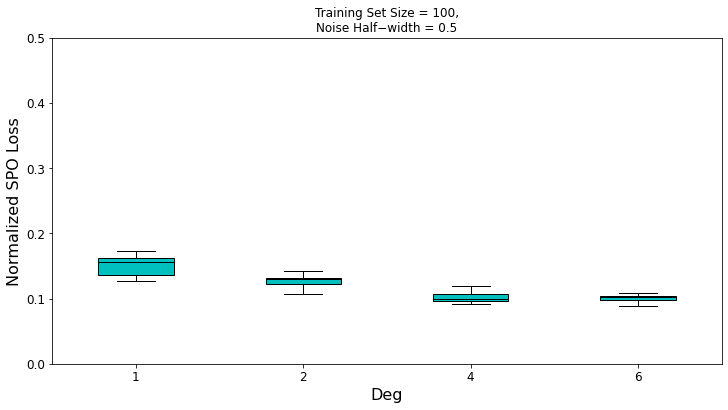

In [15]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0 

In [16]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [17]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [18]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-2
        num_epochs = 20
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.42it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.45s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.28it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.32s/it]


Normalized SPO Loss: 0.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.33it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.46s/it]


Normalized SPO Loss: 0.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.40s/it]


Normalized SPO Loss: 2.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.75it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.71s/it]


Normalized SPO Loss: 0.39%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.41it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.24s/it]


Normalized SPO Loss: 0.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 249.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.30s/it]


Normalized SPO Loss: 0.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.47s/it]


Normalized SPO Loss: 1.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.67it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.99s/it]


Normalized SPO Loss: 0.29%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 282.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.10it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.46s/it]


Normalized SPO Loss: 0.47%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.45s/it]


Normalized SPO Loss: 0.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.37s/it]


Normalized SPO Loss: 1.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.29s/it]


Normalized SPO Loss: 0.33%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.39s/it]


Normalized SPO Loss: 0.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.38it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.48s/it]


Normalized SPO Loss: 0.43%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.43it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.29s/it]


Normalized SPO Loss: 1.65%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.53it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.36s/it]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.46s/it]


Normalized SPO Loss: 0.39%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.07it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.54s/it]


Normalized SPO Loss: 0.40%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.48s/it]


Normalized SPO Loss: 1.84%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.16it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.35s/it]


Normalized SPO Loss: 0.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.10it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.29s/it]


Normalized SPO Loss: 0.36%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.42s/it]


Normalized SPO Loss: 0.38%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.39s/it]


Normalized SPO Loss: 2.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.45s/it]


Normalized SPO Loss: 0.78%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.69it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.78it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.30s/it]


Normalized SPO Loss: 0.43%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 258.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.36s/it]


Normalized SPO Loss: 0.67%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.13it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.46s/it]


Normalized SPO Loss: 1.95%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.87it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.62s/it]


Normalized SPO Loss: 0.14%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.56it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.50s/it]


Normalized SPO Loss: 0.30%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.38it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.28s/it]


Normalized SPO Loss: 0.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.31s/it]


Normalized SPO Loss: 2.27%



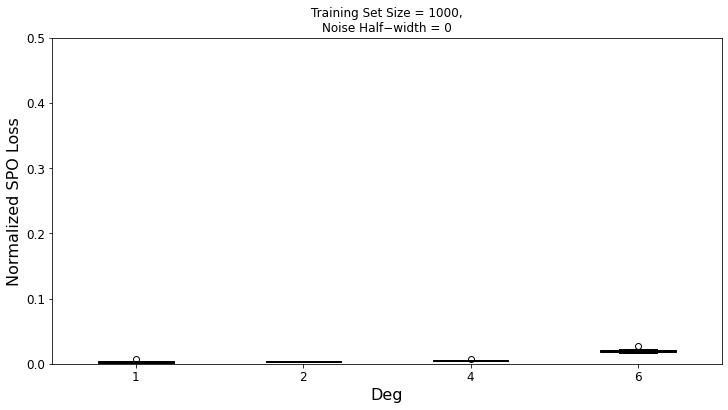

In [19]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0.5 

In [20]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [21]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [22]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 5e-2
        num_epochs = 20
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.77it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.57s/it]


Normalized SPO Loss: 10.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.24it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.42s/it]


Normalized SPO Loss: 9.54%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.43s/it]


Normalized SPO Loss: 8.20%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.81it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.31s/it]


Normalized SPO Loss: 9.49%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.60it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.32s/it]


Normalized SPO Loss: 13.33%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.38it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.42s/it]


Normalized SPO Loss: 10.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.76it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.64s/it]


Normalized SPO Loss: 7.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.40s/it]


Normalized SPO Loss: 7.63%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.80it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.30s/it]


Normalized SPO Loss: 12.33%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.97s/it]


Normalized SPO Loss: 10.85%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 202.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 229.38it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.92s/it]


Normalized SPO Loss: 9.43%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 231.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 229.20it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.60s/it]


Normalized SPO Loss: 9.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.27it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:13<00:00,  3.69s/it]


Normalized SPO Loss: 11.63%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.33it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.83s/it]


Normalized SPO Loss: 10.53%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 243.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.67it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.60s/it]


Normalized SPO Loss: 8.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.83it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.48s/it]


Normalized SPO Loss: 8.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.82it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:06<00:00,  6.30s/it]


Normalized SPO Loss: 11.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.06it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.45s/it]


Normalized SPO Loss: 10.33%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.03it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.59it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.51s/it]


Normalized SPO Loss: 8.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.99it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.37s/it]


Normalized SPO Loss: 8.68%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.61it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:49<00:00,  8.46s/it]


Normalized SPO Loss: 12.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.32it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.44it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [03:09<00:00,  9.49s/it]


Normalized SPO Loss: 9.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.69it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:43<00:00,  8.15s/it]


Normalized SPO Loss: 8.36%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.28it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.37s/it]


Normalized SPO Loss: 8.73%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.64it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  7.94s/it]


Normalized SPO Loss: 15.47%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.76it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.50s/it]


Normalized SPO Loss: 11.52%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:42<00:00,  8.14s/it]


Normalized SPO Loss: 9.26%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.93it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [02:08<00:00,  6.45s/it]


Normalized SPO Loss: 9.21%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 242.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 249.69it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:51<00:00,  5.55s/it]


Normalized SPO Loss: 11.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.37it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.76s/it]


Normalized SPO Loss: 9.58%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.59it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.51s/it]


Normalized SPO Loss: 7.99%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.49it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.62s/it]


Normalized SPO Loss: 9.45%



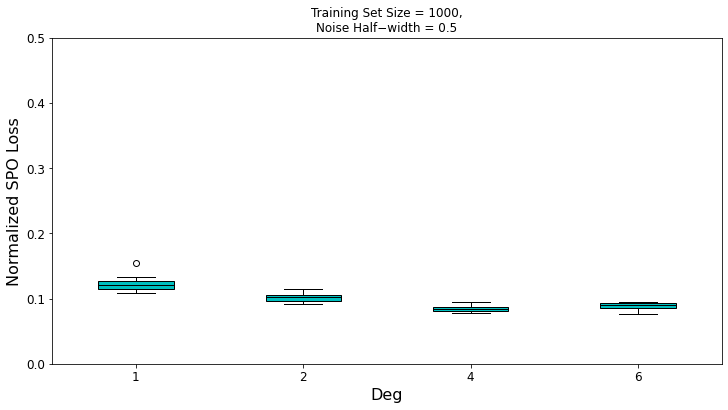

In [23]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [24]:
df1.to_csv('./res/ks/spoplus_n100.csv', index=False)
df2.to_csv('./res/ks/spoplus_n100_noise.csv', index=False)
df3.to_csv('./res/ks/spoplus_n1000.csv', index=False)
df4.to_csv('./res/ks/spoplus_n1000_noise.csv', index=False)